In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('/capstor/users/cscs/xyixuan/PDM/')

In [3]:
from ignite.metrics import RougeL
from src.verbatim_eval.utils import load_inference_data
from tqdm import tqdm
import numpy as np
from typing import List, Dict

/users/xyixuan/miniconda3/lib/python3.12/site-packages/ignite/handlers/checkpoint.py:16: DeprecationWarning: `TorchScript` support for functional optimizers is deprecated and will be removed in a future PyTorch release. Consider using the `torch.compile` optimizer instead.
  from torch.distributed.optim import ZeroRedundancyOptimizer
/users/xyixuan/miniconda3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
def batch_metric_calc(batch, true_key, gen_key, len_suffix):
    """
    Calculate ROUGE-L scores for a batch of true and generated sequences.

    Args:
        batch (dict): Batch of data containing true and generated sequences.
        true_key (str, optional): Key for true sequences. Defaults to "true_suffix".
        gen_key (str, optional): Key for generated sequences. Defaults to "generated_suffix".

    Returns:
        dict: Dictionary containing arrays of ROUGE-L scores and summary statistics.
    """


    rouge_scores = []
    ttr_ref_scores = []
    ttr_gen_scores = []
    rouge_metric = RougeL(multiref="best")

    for true_seq, gen_seq in zip(batch[true_key], batch[gen_key]):

        assert len_suffix <= len(true_seq), "Length of suffix is greater than sequence length."

        # Wrap sequences as required by the metric
        ref_slice = true_seq[:len_suffix]
        gen_slice  = gen_seq[:len_suffix]

        ttr_ref = len(set(ref_slice)) / len(ref_slice)
        ttr_gen  = len(set(gen_slice)) / len(gen_slice)

        # Reset metric for new pair
        rouge_metric.reset()
        rouge_metric.update(([ref_slice], [[gen_slice]]))
        rouge = rouge_metric.compute()
        
        # Extract F1 score
        rouge_scores.append(rouge['Rouge-L-F'])
        ttr_ref_scores.append(ttr_ref)
        ttr_gen_scores.append(ttr_gen)

    return {
        "Rouge-L": rouge_scores,
        "TTR_ref": ttr_ref_scores,
        "TTR_gen": ttr_gen_scores
    }

In [5]:
def log_metrics(results_by_experiment, metric="Rouge-L"):
    """
    Log summary of *all* metrics under each experiment and repetition.
    """
    for experiment, rep_dict in results_by_experiment.items():
        print(f"\n=== Summary for Experiment: {experiment} ===")
        for repetition, metrics_dict in rep_dict.items():
            print(f"  Repetition {repetition:3d}")
            # metrics_dict is e.g. {"Rouge-L": {...}, "TTR_ref": {...}, ...}
            for metric_name, stats in metrics_dict.items():
                print(
                    f"    {metric_name:<10} | "
                    f"Mean = {stats['mean']:.3f}, "
                    f"Std = {stats['std']:.3f}"
                )
            

def eval_metrics(base_path: str, experiments: List[str], repetitions: np.ndarray, len_suffix: int):
    """
    Evaluate the following metrics for a given experiment and repetitions.
    1. ROUGE-L
    2. TTR (Type-Token Ratio): Ratio of unique tokens to total tokens in a sequence.

    Args:
        expr (str): Name of the experiment.
        repetitions (np.ndarray): Array of repetition numbers.

    Returns:
        dict: Dictionary containing arrays of ROUGE-L scores and summary statistics.
    """
    results = {}
    
    # Load inference data
    for expr in experiments:
        results[expr] = {}

        pbar = tqdm(repetitions, desc="Processing repetition set")
        for r in pbar:
            pbar.set_description(f"Processing repetition set {r}")  
            data_path = f"{base_path}/{expr}/inference"
            data = load_inference_data(data_path, rep=r)

            # Calculate ROUGE-L scores
            eval_results = data.map(
                batch_metric_calc, 
                batched=True, 
                batch_size=10, 
                num_proc=50, 
                desc=f"Calculating metrics for rep={r}", 
                remove_columns=data.column_names,
                fn_kwargs={
                    "true_key": "true_suffix",
                    "gen_key": "generated_suffix",
                    "len_suffix": len_suffix, 
                })
            
            results[expr][r] = {}

            # Store results in dictionary
            for metric in eval_results.column_names:
                
                scores = np.array(eval_results[metric])

                results[expr][r][metric] = {
                    'scores': scores,
                    'mean': np.mean(scores),
                    'std': np.std(scores)
                }

    return results

In [6]:
def log_metrics(results, metric="Rouge-L"):
    """
    For each repetition, print the selected metric for each experiment.

    Parameters
    ----------
    results : dict
        Nested dict of form:
            {
                experiment_name: {
                    repetition_index: {
                        metric_name: {
                            'scores': np.ndarray,
                            'mean': float,
                            'std': float
                        },
                        ...
                    },
                    ...
                },
                ...
            }
    metric : str
        A single metric name to log (e.g., "Rouge-L").
    """
    # Collect and sort all repetition indices across experiments
    all_reps = sorted({rep for exp_data in results.values() for rep in exp_data})

    # Determine a suitable width for experiment name alignment:
    # e.g., find the longest experiment name and add some padding.
    max_exp_length = max(len(exp_name) for exp_name in results.keys())
    field_width = max(20, max_exp_length + 2)  # minimum 20 or expand if longer names


    # Main loop: repetition first, then each experiment
    for rep in all_reps:
        print(f"\n=== Repetition {rep} {metric} ===")
        for experiment in sorted(results.keys()):

            # Extract the metric data (e.g., {"mean": 0.7, "std": 0.05, "scores": ...})
            data = results[experiment][rep].get(metric)

            print(
                f"  {experiment:<{field_width}}: Mean = {data['mean']:.3f} | Std = {data['std']:.3f}"
            )


In [7]:
base_path = "/iopsstor/scratch/cscs/xyixuan/experiment"
repetitions_128  = np.array([1, 2, 3, 4, 8, 16, 24, 32, 48, 64, 96, 128])
repetitions_2048 = np.array([128, 256, 512, 1024, 2048])


In [14]:
goldfish_res = eval_metrics(
    base_path, 
    experiments=[
        "llama_1.5B_Sparse_Gutenberg_K_50_H_13_GBS_60_SEQ_1984000",
        "llama_1.5B_Sparse_Gutenberg_Standard_GBS_60_SEQ_1984000", 
    ], 
    repetitions=repetitions_2048,
    len_suffix=500
)

Generating train split: 500 examples [00:00, 15463.21 examples/s]/s]
Calculating metrics for rep=128 (num_proc=50): 100%|██████████| 500/500 [00:00<00:00, 609.72 examples/s]
Generating train split: 500 examples [00:00, 15346.44 examples/s]  1.67s/it]
Calculating metrics for rep=256 (num_proc=50): 100%|██████████| 500/500 [00:00<00:00, 636.91 examples/s]
Generating train split: 500 examples [00:00, 16330.16 examples/s]  1.46s/it]
Calculating metrics for rep=512 (num_proc=50): 100%|██████████| 500/500 [00:00<00:00, 643.99 examples/s]
Generating train split: 500 examples [00:00, 16863.15 examples/s],  1.39s/it]
Calculating metrics for rep=1024 (num_proc=50): 100%|██████████| 500/500 [00:00<00:00, 605.75 examples/s]
Generating train split: 500 examples [00:00, 16523.16 examples/s],  1.38s/it]
Processing repetition set 2048: 100%|██████████| 5/5 [00:01<00:00,  3.09it/s]


In [15]:
goldfish_res = eval_metrics(
    base_path, 
    experiments=[
        "llama_1.5B_Sparse_Gutenberg_K_50_H_13_GBS_60_SEQ_1984000",
        "llama_1.5B_Sparse_Gutenberg_Standard_GBS_60_SEQ_1984000",
    ], 
    repetitions=repetitions_2048,
    len_suffix=500
)

Processing repetition set 128:   0%|          | 0/5 [00:00<?, ?it/s]

Processing repetition set 2048: 100%|██████████| 5/5 [00:01<00:00,  3.34it/s]


In [16]:
log_metrics(goldfish_res, metric='Rouge-L')


=== Repetition 128 Rouge-L ===
  llama_1.5B_Sparse_Gutenberg_K_50_H_13_GBS_60_SEQ_1984000  : Mean = 0.300 | Std = 0.139
  llama_1.5B_Sparse_Gutenberg_Standard_GBS_60_SEQ_1984000   : Mean = 0.992 | Std = 0.077

=== Repetition 256 Rouge-L ===
  llama_1.5B_Sparse_Gutenberg_K_50_H_13_GBS_60_SEQ_1984000  : Mean = 0.283 | Std = 0.119
  llama_1.5B_Sparse_Gutenberg_Standard_GBS_60_SEQ_1984000   : Mean = 0.992 | Std = 0.074

=== Repetition 512 Rouge-L ===
  llama_1.5B_Sparse_Gutenberg_K_50_H_13_GBS_60_SEQ_1984000  : Mean = 0.284 | Std = 0.124
  llama_1.5B_Sparse_Gutenberg_Standard_GBS_60_SEQ_1984000   : Mean = 0.991 | Std = 0.069

=== Repetition 1024 Rouge-L ===
  llama_1.5B_Sparse_Gutenberg_K_50_H_13_GBS_60_SEQ_1984000  : Mean = 0.287 | Std = 0.119
  llama_1.5B_Sparse_Gutenberg_Standard_GBS_60_SEQ_1984000   : Mean = 0.995 | Std = 0.048

=== Repetition 2048 Rouge-L ===
  llama_1.5B_Sparse_Gutenberg_K_50_H_13_GBS_60_SEQ_1984000  : Mean = 0.281 | Std = 0.116
  llama_1.5B_Sparse_Gutenberg_Standar

In [17]:
log_metrics(goldfish_res, metric='TTR_ref')


=== Repetition 128 TTR_ref ===
  llama_1.5B_Sparse_Gutenberg_K_50_H_13_GBS_60_SEQ_1984000  : Mean = 0.541 | Std = 0.055
  llama_1.5B_Sparse_Gutenberg_Standard_GBS_60_SEQ_1984000   : Mean = 0.541 | Std = 0.055

=== Repetition 256 TTR_ref ===
  llama_1.5B_Sparse_Gutenberg_K_50_H_13_GBS_60_SEQ_1984000  : Mean = 0.541 | Std = 0.053
  llama_1.5B_Sparse_Gutenberg_Standard_GBS_60_SEQ_1984000   : Mean = 0.541 | Std = 0.053

=== Repetition 512 TTR_ref ===
  llama_1.5B_Sparse_Gutenberg_K_50_H_13_GBS_60_SEQ_1984000  : Mean = 0.539 | Std = 0.045
  llama_1.5B_Sparse_Gutenberg_Standard_GBS_60_SEQ_1984000   : Mean = 0.539 | Std = 0.045

=== Repetition 1024 TTR_ref ===
  llama_1.5B_Sparse_Gutenberg_K_50_H_13_GBS_60_SEQ_1984000  : Mean = 0.539 | Std = 0.048
  llama_1.5B_Sparse_Gutenberg_Standard_GBS_60_SEQ_1984000   : Mean = 0.539 | Std = 0.048

=== Repetition 2048 TTR_ref ===
  llama_1.5B_Sparse_Gutenberg_K_50_H_13_GBS_60_SEQ_1984000  : Mean = 0.538 | Std = 0.049
  llama_1.5B_Sparse_Gutenberg_Standar

In [18]:
log_metrics(goldfish_res, metric='TTR_gen')


=== Repetition 128 TTR_gen ===
  llama_1.5B_Sparse_Gutenberg_K_50_H_13_GBS_60_SEQ_1984000  : Mean = 0.550 | Std = 0.047
  llama_1.5B_Sparse_Gutenberg_Standard_GBS_60_SEQ_1984000   : Mean = 0.541 | Std = 0.055

=== Repetition 256 TTR_gen ===
  llama_1.5B_Sparse_Gutenberg_K_50_H_13_GBS_60_SEQ_1984000  : Mean = 0.557 | Std = 0.046
  llama_1.5B_Sparse_Gutenberg_Standard_GBS_60_SEQ_1984000   : Mean = 0.541 | Std = 0.053

=== Repetition 512 TTR_gen ===
  llama_1.5B_Sparse_Gutenberg_K_50_H_13_GBS_60_SEQ_1984000  : Mean = 0.562 | Std = 0.041
  llama_1.5B_Sparse_Gutenberg_Standard_GBS_60_SEQ_1984000   : Mean = 0.539 | Std = 0.046

=== Repetition 1024 TTR_gen ===
  llama_1.5B_Sparse_Gutenberg_K_50_H_13_GBS_60_SEQ_1984000  : Mean = 0.565 | Std = 0.044
  llama_1.5B_Sparse_Gutenberg_Standard_GBS_60_SEQ_1984000   : Mean = 0.539 | Std = 0.048

=== Repetition 2048 TTR_gen ===
  llama_1.5B_Sparse_Gutenberg_K_50_H_13_GBS_60_SEQ_1984000  : Mean = 0.566 | Std = 0.040
  llama_1.5B_Sparse_Gutenberg_Standar

In [19]:
import matplotlib.pyplot as plt

def plot_ttr_dists(
    goldfish_res: dict,
    repetitions: list[int],
    metric: str,
):
    """
    Plot the distributions of TTR (Type-Token Ratio) scores for multiple repetitions.

    Parameters
    ----------
    expr : str
        An identifier or label for the experiment/model grouping.
    repetitions : list[int]
        A list of repetition indices (e.g., [1, 2, 3, 4]).
    goldfish_res : dict
        Nested dict of model evaluation results. For example:
            goldfish_res[model_name][rep]['TTR_gen']['scores'] = np.array(...)
            goldfish_res[model_name][rep]['TTR_ref']['scores'] = np.array(...)
    """
    n_reps = len(repetitions)
    
    # Decide on subplot arrangement: up to 3 columns, rows as needed
    n_cols = min(3, n_reps)  
    n_rows = (n_reps + n_cols - 1) // n_cols  # "ceiling" division

    # Create figure and subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
    fig.suptitle(f"{metric} Distributions")

    # If multiple rows, flatten axes to 1D for easy indexing
    if n_rows > 1:
        axes = axes.ravel()

    # Plot each repetition
    for idx, rep in enumerate(repetitions):
        # For example, we have two model outputs + reference:
        #   model1 = "llama_1.5B_Sparse_Gutenberg_Standard_GBS_60"
        #   model2 = "llama_1.5B_Sparse_Gutenberg_K_50_H_13_GBS_60"
        # We assume you want TTR_gen from both, and TTR_ref from the second.
        if metric == "TTR":
            # arr1 = goldfish_res["llama_1.5B_Sparse_Gutenberg_Standard_GBS_60"][rep]["TTR_gen"]["scores"]
            # arr2 = goldfish_res["llama_1.5B_Sparse_Gutenberg_K_50_H_13_GBS_60"][rep]["TTR_gen"]["scores"]
            # arr3 = goldfish_res["llama_1.5B_Sparse_Gutenberg_K_50_H_13_GBS_60"][rep]["TTR_ref"]["scores"]

            # ax = axes[idx]
            
            # # Plot histograms
            # ax.hist(arr1, bins=30, alpha=0.5, label='Standard TTR_gen')
            # ax.hist(arr2, bins=30, alpha=0.5, label='Goldfish TTR_gen')
            # ax.hist(arr3, bins=30, alpha=0.5, label='Reference TTR_ref')

            arr1 = goldfish_res["llama_1.5B_Sparse_Gutenberg_Standard_GBS_60_SEQ_11971350"][rep]["TTR_gen"]["scores"]
            arr2 = goldfish_res["llama_1.5B_Sparse_Gutenberg_Standard_GBS_60_SEQ_11971350"][rep]["TTR_ref"]["scores"]

            ax = axes[idx]
            
            # Plot histograms
            ax.hist(arr1, bins=30, alpha=0.5, label='Standard TTR_gen')
            ax.hist(arr2, bins=30, alpha=0.5, label='Reference TTR_ref')

            ax.set_xlabel("TTR Score")

        elif metric == "Rouge-L":
            # arr1 = goldfish_res["llama_1.5B_Sparse_Gutenberg_Standard_GBS_60"][rep]["Rouge-L"]["scores"]
            # arr2 = goldfish_res["llama_1.5B_Sparse_Gutenberg_K_50_H_13_GBS_60"][rep]["Rouge-L"]["scores"]

            # ax = axes[idx]
            
            # # Plot histograms
            # ax.hist(arr1, bins=30, alpha=0.5, label='Standard Rouge-L')
            # ax.hist(arr2, bins=30, alpha=0.5, label='Goldfish Rouge-L')

            arr1 = goldfish_res["llama_1.5B_Sparse_Gutenberg_Standard_GBS_60_SEQ_11971350"][rep]["Rouge-L"]["scores"]
            ax = axes[idx]
            ax.hist(arr1, bins=30, alpha=0.5, label='Standard Rouge-L')

            ax.set_xlabel("Rouge-L Score")
            ax.set_xlim(0, 1)  # Set y-axis limit to 500
            ax.set_yscale('log')

        else:
            raise ValueError(f"Unknown metric: {metric}, available options: 'TTR', 'Rouge-L'")

        ax.set_ylabel("Frequency")
        ax.set_title(f"Rep {rep}")
        ax.legend()
        ax.grid(axis='y', alpha=0.75)
        # Example of setting log scale on Y-axis:
        # ax.set_yscale('log')

    # Remove any unused subplots (e.g., if n_reps < n_rows*n_cols)
    for idx in range(n_reps, n_rows * n_cols):
        fig.delaxes(axes[idx])

    plt.tight_layout()
    plt.show()


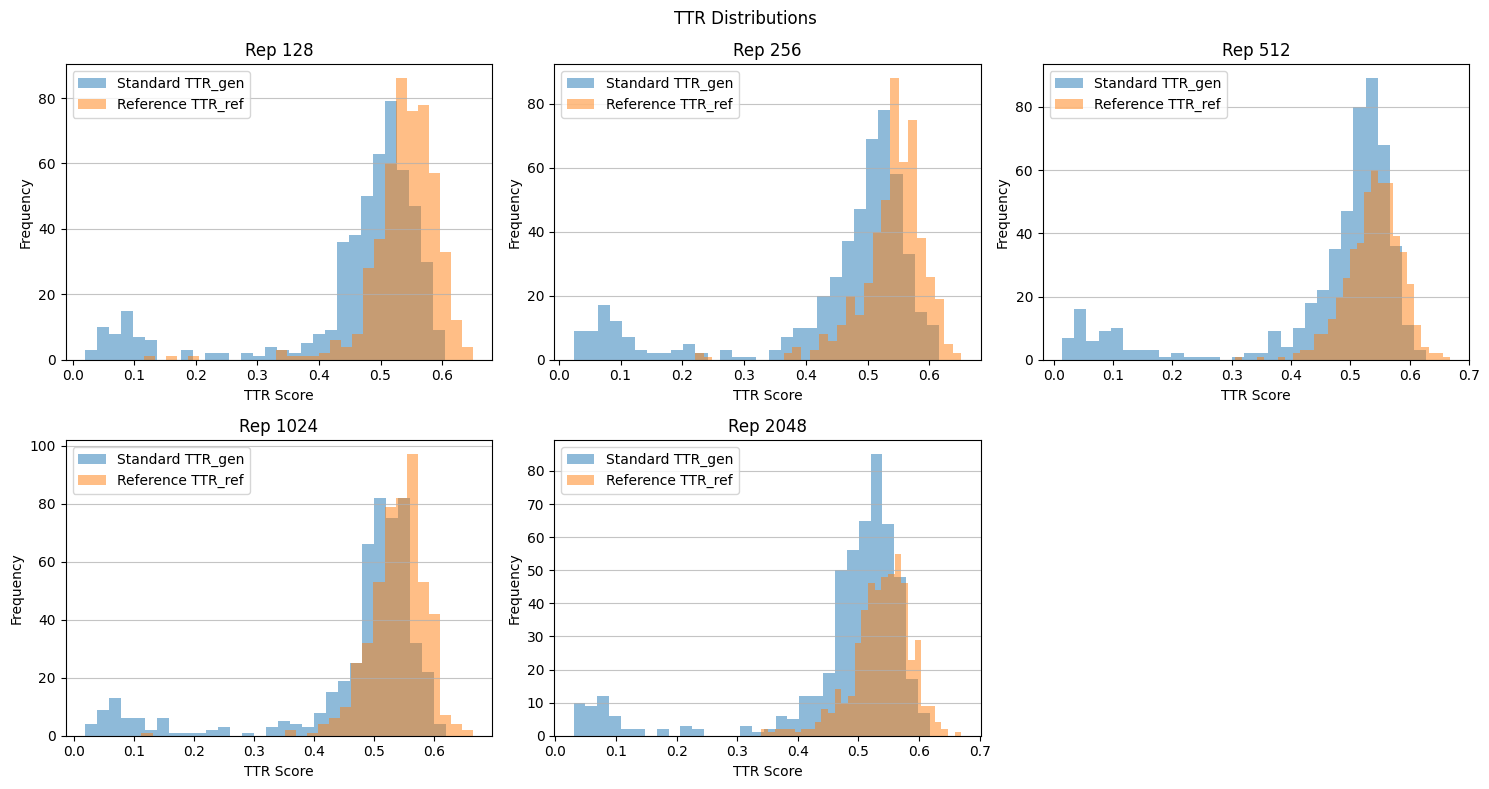

In [17]:
plot_ttr_dists(goldfish_res, repetitions_2048, metric='TTR')

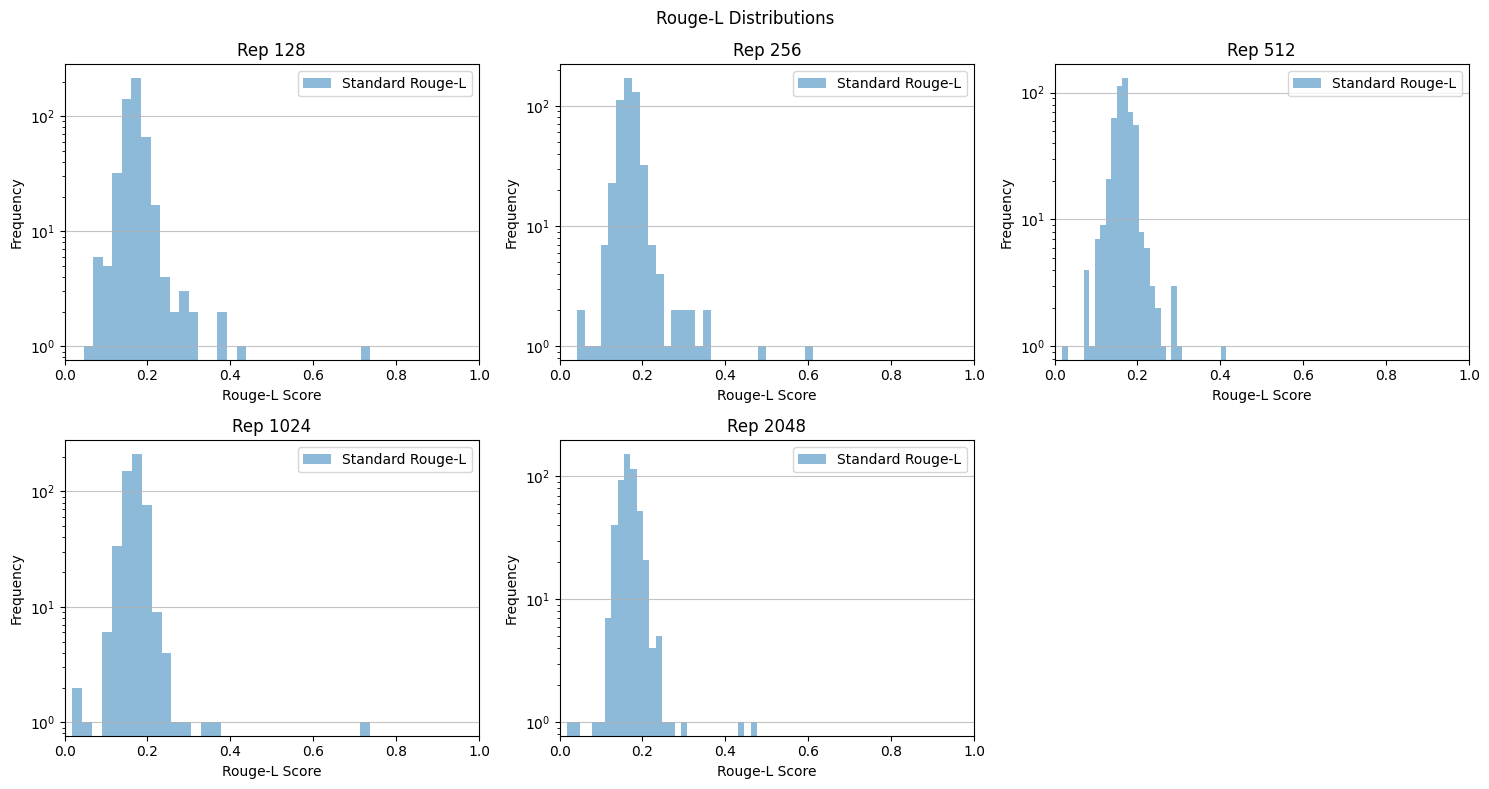

In [20]:
plot_ttr_dists(goldfish_res, repetitions_2048, metric='Rouge-L')

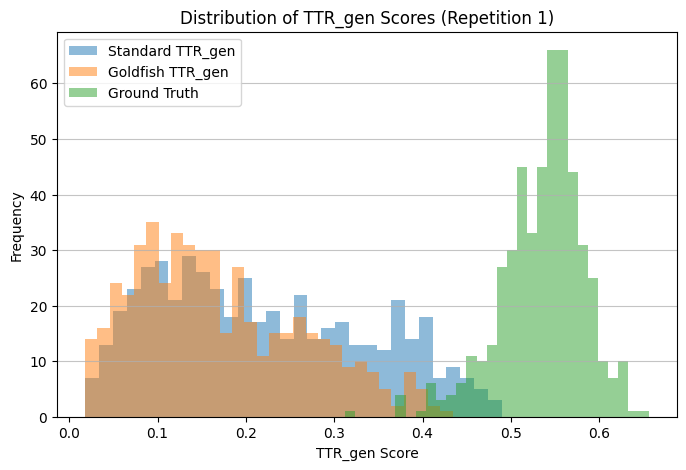

In [179]:
import matplotlib.pyplot as plt
import numpy as np

rep = 1
# Extract the scores
arr1 = goldfish_res['llama_1.5B_Sparse_Gutenberg_Standard_GBS_60'][rep]['TTR_gen']['scores']
arr2 = goldfish_res['llama_1.5B_Sparse_Gutenberg_K_50_H_13_GBS_60'][rep]['TTR_gen']['scores']
arr3 = goldfish_res['llama_1.5B_Sparse_Gutenberg_K_50_H_13_GBS_60'][rep]['TTR_ref']['scores']

# Plot histograms
plt.figure(figsize=(8, 5))
plt.hist(arr1, bins=30, alpha=0.5, label='Standard TTR_gen')
plt.hist(arr2, bins=30, alpha=0.5, label='Goldfish TTR_gen')
plt.hist(arr3, bins=30, alpha=0.5, label='Ground Truth')

plt.title(f"Distribution of TTR_gen Scores (Repetition {rep})")
plt.xlabel("TTR_gen Score")
plt.ylabel("Frequency")
plt.legend()
plt.grid(axis='y', alpha=0.75)
plt.show()


In [174]:
goldfish_res['llama_1.5B_Sparse_Gutenberg_K_50_H_13_GBS_60'][1]['TTR_gen']['scores']

array([0.324, 0.214, 0.302, 0.288, 0.334, 0.104, 0.042, 0.16 , 0.294,
       0.226, 0.208, 0.302, 0.326, 0.046, 0.3  , 0.246, 0.304, 0.152,
       0.188, 0.272, 0.076, 0.058, 0.106, 0.144, 0.03 , 0.022, 0.228,
       0.176, 0.282, 0.05 , 0.28 , 0.184, 0.168, 0.044, 0.23 , 0.124,
       0.292, 0.144, 0.082, 0.084, 0.058, 0.108, 0.41 , 0.15 , 0.322,
       0.018, 0.12 , 0.164, 0.144, 0.192, 0.276, 0.162, 0.09 , 0.212,
       0.022, 0.336, 0.03 , 0.322, 0.08 , 0.264, 0.186, 0.346, 0.048,
       0.144, 0.07 , 0.36 , 0.198, 0.202, 0.06 , 0.402, 0.124, 0.336,
       0.334, 0.188, 0.096, 0.134, 0.088, 0.05 , 0.138, 0.394, 0.208,
       0.228, 0.242, 0.114, 0.028, 0.186, 0.19 , 0.236, 0.176, 0.19 ,
       0.108, 0.126, 0.434, 0.03 , 0.294, 0.142, 0.036, 0.396, 0.338,
       0.32 , 0.126, 0.208, 0.106, 0.284, 0.158, 0.184, 0.042, 0.152,
       0.216, 0.276, 0.238, 0.246, 0.162, 0.196, 0.116, 0.194, 0.278,
       0.15 , 0.322, 0.372, 0.052, 0.238, 0.128, 0.146, 0.082, 0.07 ,
       0.106, 0.132,

In [113]:
log_metrics(goldfish_res)


=== Summary for Experiment: llama_1.5B_Sparse_Gutenberg_K_50_H_13_GBS_60 ===
  Repetition   1
    Rouge-L    | Mean = 0.184, Std = 0.051
    TTR_ref    | Mean = 0.725, Std = 0.064
    TTR_gen    | Mean = 0.469, Std = 0.143
  Repetition   2
    Rouge-L    | Mean = 0.186, Std = 0.061
    TTR_ref    | Mean = 0.731, Std = 0.064
    TTR_gen    | Mean = 0.458, Std = 0.138
  Repetition   3
    Rouge-L    | Mean = 0.183, Std = 0.045
    TTR_ref    | Mean = 0.730, Std = 0.056
    TTR_gen    | Mean = 0.464, Std = 0.138
  Repetition   4
    Rouge-L    | Mean = 0.185, Std = 0.054
    TTR_ref    | Mean = 0.725, Std = 0.065
    TTR_gen    | Mean = 0.468, Std = 0.135
  Repetition   8
    Rouge-L    | Mean = 0.189, Std = 0.058
    TTR_ref    | Mean = 0.728, Std = 0.059
    TTR_gen    | Mean = 0.478, Std = 0.135
  Repetition  16
    Rouge-L    | Mean = 0.190, Std = 0.051
    TTR_ref    | Mean = 0.728, Std = 0.059
    TTR_gen    | Mean = 0.510, Std = 0.146
  Repetition  24
    Rouge-L    | Mean = 0.189

In [64]:
eval_rougeL(base_path, "llama_1.5B_Sparse_Gutenberg_K_50_H_13_GBS_60", repetitions, metric='TTR_gen')

Processing repetition set 128: 100%|██████████| 12/12 [00:05<00:00,  2.01it/s]


Summary of llama_1.5B_Sparse_Gutenberg_K_50_H_13_GBS_60 TTR_gen score:
Repetition   1: Mean = 0.635 ± 0.139
Repetition   2: Mean = 0.627 ± 0.134
Repetition   3: Mean = 0.633 ± 0.138
Repetition   4: Mean = 0.639 ± 0.134
Repetition   8: Mean = 0.646 ± 0.128
Repetition  16: Mean = 0.663 ± 0.133
Repetition  24: Mean = 0.700 ± 0.129
Repetition  32: Mean = 0.691 ± 0.134
Repetition  48: Mean = 0.722 ± 0.124
Repetition  64: Mean = 0.726 ± 0.110
Repetition  96: Mean = 0.739 ± 0.109
Repetition 128: Mean = 0.742 ± 0.118


In [65]:
eval_rougeL(base_path, "llama_1.5B_Sparse_Gutenberg_Standard_GBS_60", repetitions, metric='TTR_gen')

Processing repetition set 128: 100%|██████████| 12/12 [00:06<00:00,  1.80it/s]


Summary of llama_1.5B_Sparse_Gutenberg_Standard_GBS_60 TTR_gen score:
Repetition   1: Mean = 0.667 ± 0.125
Repetition   2: Mean = 0.666 ± 0.132
Repetition   3: Mean = 0.667 ± 0.131
Repetition   4: Mean = 0.674 ± 0.125
Repetition   8: Mean = 0.673 ± 0.130
Repetition  16: Mean = 0.676 ± 0.119
Repetition  24: Mean = 0.689 ± 0.116
Repetition  32: Mean = 0.692 ± 0.123
Repetition  48: Mean = 0.695 ± 0.121
Repetition  64: Mean = 0.707 ± 0.115
Repetition  96: Mean = 0.703 ± 0.109
Repetition 128: Mean = 0.705 ± 0.122


In [29]:
data_rouge['Rouge-L']

[0.172,
 0.208,
 0.238,
 0.144,
 0.156,
 0.176,
 0.192,
 0.154,
 0.146,
 0.174,
 0.17,
 0.156,
 0.218,
 0.156,
 0.18,
 0.198,
 0.17,
 0.178,
 0.18,
 0.13,
 0.158,
 0.19600000000000004,
 0.234,
 0.19600000000000004,
 0.17,
 0.188,
 0.134,
 0.134,
 0.188,
 0.184,
 0.208,
 0.20999999999999996,
 0.202,
 0.168,
 0.16,
 0.15,
 0.156,
 0.158,
 0.138,
 0.19,
 0.114,
 0.188,
 0.062,
 0.18,
 0.18,
 0.164,
 0.19,
 0.188,
 0.184,
 0.128,
 0.152,
 0.202,
 0.134,
 0.222,
 0.278,
 0.186,
 0.216,
 0.148,
 0.152,
 0.204,
 0.174,
 0.182,
 0.172,
 0.126,
 0.156,
 0.204,
 0.194,
 0.258,
 0.208,
 0.206,
 0.138,
 0.186,
 0.19,
 0.138,
 0.314,
 0.18,
 0.14,
 0.18,
 0.174,
 0.206,
 0.148,
 0.156,
 0.158,
 0.176,
 0.166,
 0.178,
 0.184,
 0.128,
 0.178,
 0.186,
 0.178,
 0.212,
 0.204,
 0.202,
 0.168,
 0.166,
 0.176,
 0.194,
 0.18,
 0.19,
 0.156,
 0.19600000000000004,
 0.222,
 0.154,
 0.206,
 0.168,
 0.146,
 0.246,
 0.124,
 0.156,
 0.168,
 0.15,
 0.184,
 0.148,
 0.17,
 0.202,
 0.144,
 0.154,
 0.192,
 0.18,
 0.18